In [1]:
import pandas as pd

from src.algorithms.alternating_least_squares import AlternatingLeastSquares
from src.helpers.dataset_indexer import DatasetIndexer
from src.helpers.checkpoint_manager import CheckpointManager
from src.recommenders import CollaborativeFilteringRecommenderBuilder
from src.backends import Backend
from src.helpers._logging import logger  # noqa
from src.settings import settings

from src.helpers.graphing import (
    plot_als_train_test_loss_evolution,
    plot_als_train_test_rmse_evolution,
    # plot_error_evolution,
    plot_power_low_distribution,
    plot_data_item_distribution_as_hist,
)

In [2]:
dataset_indexer = DatasetIndexer(
    file_path="./ml-32m/ratings.csv",
    user_header="userId",
    item_header="movieId",
    rating_header="rating",
    limit=settings.general.LINES_COUNT_TO_READ,
)

indexed_data = dataset_indexer.index_simple(
    approximate_train_ratio=settings.general.APPROXIMATE_TRAIN_RATIO
)

2025-01-07 14:26:35,998 [WARNING] The current implementation does not split the data into train and test sets exactly with the provided ratio. We use the provided ratio as a probability for a Bernoulli distribution to know whether a given data point should be used as a training data or a test data.
2025-01-07 14:26:42,268 [WARNING] The limit of lines (.i.e 1000000) to index has been reached. Exiting without loading the rest... 
2025-01-07 14:26:42,269 [INFO] Successfully indexed 1000000 lines from ./ml-32m/ratings.csv


In [3]:
# Import the movie csv file that will act as our movie database
# And that database is needed by the backend to query the movies
item_database = (
    pd.read_csv("./ml-32m/movies.csv", dtype={"movieId": str})
    .set_index("movieId")
    .to_dict(orient="index")
)

In [4]:
# plot_data_item_distribution_as_hist(indexed_data)

In [5]:
# plot_power_low_distribution(indexed_data,)

In [6]:
als_instance = AlternatingLeastSquares(
    hyper_lambda=settings.als.HYPER_LAMBDA,
    hyper_gamma=settings.als.HYPER_GAMMA,
    hyper_tau=settings.als.HYPER_TAU,
    hyper_n_epochs=settings.als.HYPER_N_EPOCH,
    hyper_n_factors=settings.als.HYPER_N_FACTOR,
)

als_backend = Backend(
    # Define the algorithm
    algorithm=als_instance,
    checkpoint_manager=CheckpointManager(
        checkpoint_folder=settings.als.CHECKPOINT_FOLDER,
        sub_folder=str(settings.general.LINES_COUNT_TO_READ),
    ),
    # The predictor needs this to render the name of the items
    item_database=item_database,
    # Whether we should resume by using the last state of
    # the algorithm the checkpoint manager folder or not.
    resume=False,
    save_checkpoint=True,
)

In [7]:
recommender_builder = CollaborativeFilteringRecommenderBuilder(
    backend=als_backend,
)

# This might take some moment before finishing
recommender = recommender_builder.build(data=indexed_data)

2025-01-07 14:26:43,172 [INFO] Starting the build of the recommender using AlternatingLeastSquares...
2025-01-07 14:26:43,174 [INFO] Starting a model fitting using the backend AlternatingLeastSquares...
2025-01-07 14:26:43,200 [INFO] Checkpoint ./artifacts/checkpoints/als/1000000/20250107-031619_lambda0.1_gamma0.01_tau1_n_epochs30_n_factors10.pkl loaded with success
2025-01-07 14:26:43,201 [INFO] All factors and biases are already provided, so no initialization is needed.
2025-01-07 14:26:43,202 [ERROR] Cannot train the model more because hyperparameter 'hyper_n_epochs' (30) is already greater or equal to the final number of epochs wanted which is 30. Please check the value of 'hyper_n_epochs' and adjust accordingly. Exiting...
2025-01-07 14:26:43,203 [INFO] Successfully built the recommender using AlternatingLeastSquares


In [8]:
# plot_als_train_test_rmse_evolution(als_backend.algorithm)

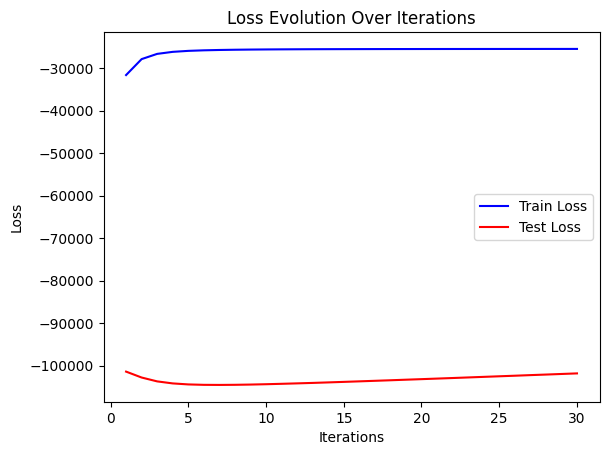

In [11]:
# plot_als_train_test_loss_evolution(als_backend.algorithm)

In [10]:
#
prediction_input = [("17", 4)]
recommender.recommend(prediction_input)

[{'title': 'Back To The Sea (2012)', 'genres': 'Animation|Children'},
 {'title': 'Afflicted, The (2010)', 'genres': 'Horror|Thriller'},
 {'title': 'The Last House on the Beach (1978)',
  'genres': 'Crime|Drama|Horror|Thriller'},
 {'title': 'Jeffrey Dahmer Files, The (2012)', 'genres': 'Crime|Documentary'},
 {'title': 'Paradise (1982)', 'genres': 'Adventure|Romance'},
 {'title': 'On Our Merry Way (1948)', 'genres': 'Comedy'},
 {'title': 'Love in Bloom (1935)', 'genres': 'Romance'},
 {'title': 'Story of G.I. Joe (1945)', 'genres': 'War'},
 {'title': 'In Old California (1942)', 'genres': 'Western'},
 {'title': 'Daisy (2006)', 'genres': 'Drama|Romance'}]

In [15]:
prediction_input = [("267654", 4)]  # Harry Poter
recommender.recommend(prediction_input)

[{'title': 'Back To The Sea (2012)', 'genres': 'Animation|Children'},
 {'title': 'Afflicted, The (2010)', 'genres': 'Horror|Thriller'},
 {'title': 'The Last House on the Beach (1978)',
  'genres': 'Crime|Drama|Horror|Thriller'},
 {'title': 'Jeffrey Dahmer Files, The (2012)', 'genres': 'Crime|Documentary'},
 {'title': 'Paradise (1982)', 'genres': 'Adventure|Romance'},
 {'title': 'Love in Bloom (1935)', 'genres': 'Romance'},
 {'title': 'Story of G.I. Joe (1945)', 'genres': 'War'},
 {'title': 'In Old California (1942)', 'genres': 'Western'},
 {'title': 'On Our Merry Way (1948)', 'genres': 'Comedy'},
 {'title': 'Daisy (2006)', 'genres': 'Drama|Romance'}]